# Metadata

```yaml
Course:   DS5001: Exploratory Text Analytics
Topic:    Final Project, Models
Author:   Andrew Avitabile
Date:     24 March 2024 (Edited April 25, 2024)
```

# Set Up

## Packages

In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.linalg import norm, eigh
from sklearn.decomposition import PCA
import plotly_express as px
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA

from afinn import Afinn

#BERT transformers
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.nn.functional import softmax
import torch

In [7]:
# Define the base path
base_path = "C:/Users/Andre/Box/DS5001 Final Project/"

## Import data

In [3]:
# Data files that take less time to import
LIB = pd.read_csv(base_path + "output/LIB.csv", delimiter = "|").set_index('observationid')
CORPUS = pd.read_csv(base_path + "output/CORPUS.csv", delimiter = "|").set_index(['observationid', 'sentence_num', 'token_num'])
VOCAB = pd.read_csv(base_path + "output/VOCAB.csv", delimiter = "|").set_index('term_str')
SENTENCES = pd.read_csv(base_path + "output/SENTENCES.csv", delimiter = "|").set_index(['observationid', 'sentence_num'])
BOW_document = pd.read_csv(base_path + "output/BOW_document.csv", sep='|').set_index('observationid')

In [51]:
# These take longer to import
TFIDF_L2 = pd.read_csv(base_path + "output/TFIDF_L2.csv", delimiter = "|").set_index('observationid')

In [13]:
# Replace NaN values with an empty string (or another placeholder)
CORPUS['term_str'] = CORPUS['term_str'].fillna('')

# Models

## Principal Component Analysis (PCA)

In [52]:
TFIDF_L2 = TFIDF_L2.fillna(0)

In [53]:
def get_pca(TFIDF, 
            k=10, 
            norm_docs=True,
            norm_level=2,
            center_by_mean=True, 
            center_by_variance=False):
    
    if norm_docs:
        # TFIDF = TFIDF.apply(lambda x: x / norm(x), 1).fillna(0)
        TFIDF = (TFIDF.T / norm(TFIDF, 2, axis=1)).T
    
    if center_by_mean:
        TFIDF = TFIDF - TFIDF.mean()
        
    if center_by_variance:
        TFIDF = TFIDF / TFIDF.std()        

    COV = TFIDF.cov()

    eig_vals, eig_vecs = eigh(COV)
    
    EIG_VEC = pd.DataFrame(eig_vecs, index=COV.index, columns=COV.index)
    EIG_VAL = pd.DataFrame(eig_vals, index=COV.index, columns=['eig_val'])
    EIG_VAL.index.name = 'term_str'
        
    EIG_IDX = EIG_VAL.eig_val.sort_values(ascending=False).head(k)
    
    COMPS = EIG_VEC[EIG_IDX.index].T
    COMPS.index = [i for i in range(COMPS.shape[0])]
    COMPS.index.name = 'pc_id'
    

    LOADINGS = COMPS.T

    DCM = TFIDF.dot(LOADINGS)
    
    COMPINF = pd.DataFrame(index=COMPS.index)

    for i in range(k):
        for j in [0, 1]:
            top_terms = ' '.join(LOADINGS.sort_values(i, ascending=bool(j)).head(10).index.to_list())
            COMPINF.loc[i, j] = top_terms
    COMPINF = COMPINF.rename(columns={0:'pos', 1:'neg'})
    
    COMPINF['eig_val'] = EIG_IDX.reset_index(drop=True).to_frame()
    COMPINF['exp_var'] = COMPINF.eig_val / COMPINF.eig_val.sum()
    
    return LOADINGS, DCM, COMPINF

In [54]:
LOADINGS, DCM, COMPINF = get_pca(TFIDF_L2,
                                 k=4,
                                 norm_docs=True, 
                                 norm_level=2, 
                                 center_by_mean=False, 
                                 center_by_variance=False)

In [55]:
LOADINGS.sort_index()

pc_id,0,1,2,3
term_str,,,,
%,0.012343,0.031390,-0.009694,-0.004116
1st,0.002708,0.012270,-0.003641,-0.004734
2nd,-0.003413,0.001416,0.007628,-0.005960
3rd,-0.003841,-0.001098,0.006534,-0.005195
4th,-0.007137,0.003821,0.013564,-0.006097
...,...,...,...,...
writing,0.031967,0.030786,0.060894,0.026154
wrong,0.004077,0.007596,0.001046,0.001547
year,-0.032573,0.020853,-0.013046,-0.037989


In [56]:
LOADINGS.to_csv(base_path + "output/LOADINGS.csv", sep='|', index=True)

In [57]:
LIB_NOMISSING = LIB.dropna(how='all',  subset=['overallcomments'])

In [58]:
DCM

pc_id,0,1,2,3
observationid,,,,
0,0.076909,0.064850,0.008218,-0.028292
1,0.069597,0.085053,-0.025670,-0.011875
2,0.096067,-0.097945,-0.193270,0.102880
3,-0.001107,-0.063883,-0.061111,-0.023972
4,0.036973,0.048202,-0.039506,-0.094055
...,...,...,...,...
19003,0.007222,0.073149,0.020716,-0.092120
19004,0.086614,-0.043146,-0.078408,-0.041573
19005,0.037679,0.109628,0.063763,0.029519


In [59]:
DCM.to_csv(base_path + "output/DCM.csv", sep='|', index=True)

In [60]:
COMPINF

,pos,neg,eig_val,exp_var
pc_id,,,,
0,objective learning practice activity praise sp...,teacher great teaching confident confidence gr...,0.011066,0.333267
1,class objective work board learn room time lev...,instruction positive student specific lesson s...,0.008630,0.259906
2,group see activity instruction reading small p...,management classroom strong teacher behavior e...,0.007211,0.217184
3,today rating overall strong voice assertive go...,teaching student teacher growth learning see s...,0.006297,0.189642


In [61]:
COMPINF.to_csv(base_path + "output/COMPINF.csv", sep='|', index=True)

### PCA Vizualizations

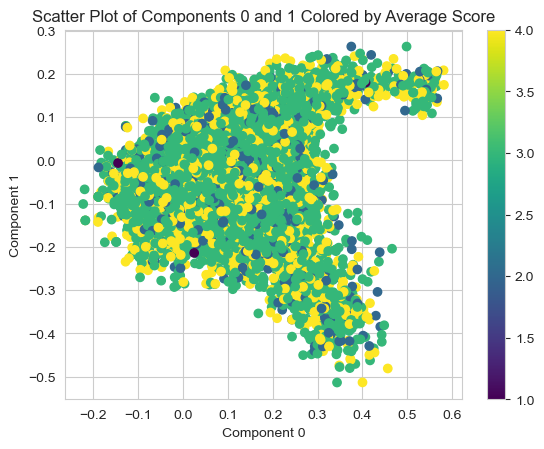

In [62]:
plt.scatter(DCM.iloc[:, 0], DCM.iloc[:, 1], c=LIB_NOMISSING.overallrating_num, cmap='viridis')
plt.colorbar()  # Shows the color scale
plt.title('Scatter Plot of Components 0 and 1 Colored by Average Score')
plt.xlabel('Component 0')
plt.ylabel('Component 1')
plt.show()

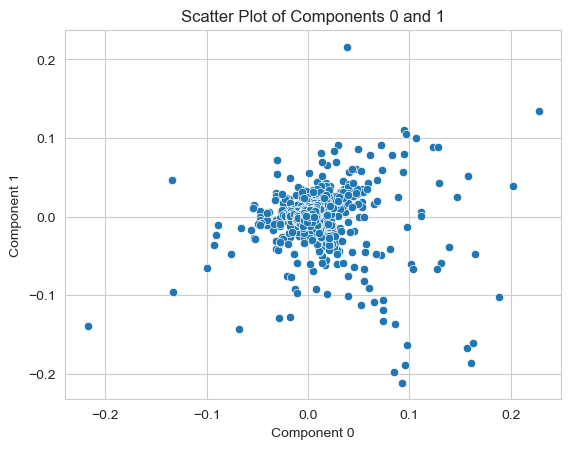

In [64]:
# Create a scatterplot
sns.scatterplot(x=LOADINGS.iloc[:, 0], y=LOADINGS.iloc[:, 1])
plt.title('Scatter Plot of Components 0 and 1')
plt.xlabel('Component 0')
plt.ylabel('Component 1')
plt.show()

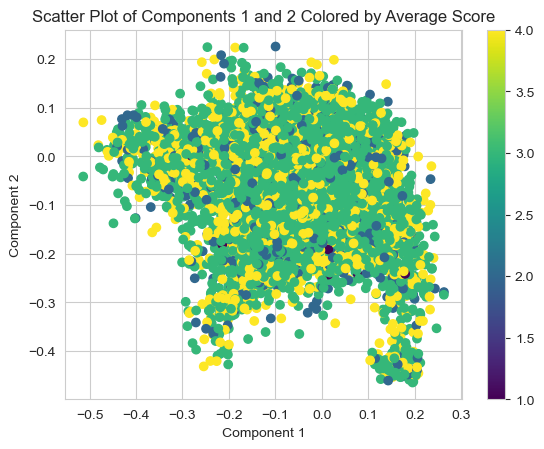

In [80]:
plt.scatter(DCM.iloc[:, 1], DCM.iloc[:, 2], c=LIB_NOMISSING.overallrating_num, cmap='viridis')
plt.colorbar()  # Shows the color scale
plt.title('Scatter Plot of Components 1 and 2 Colored by Average Score')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.show()

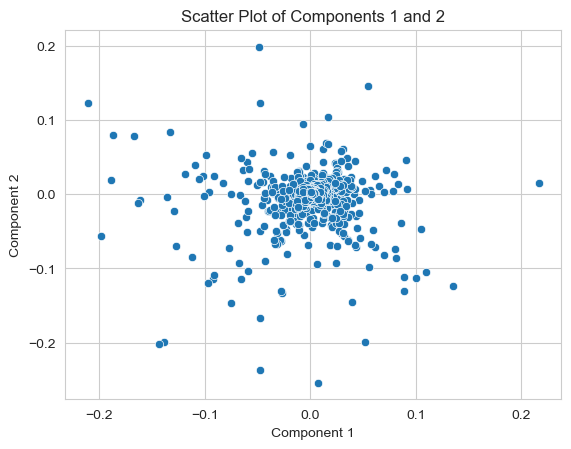

In [81]:
# Create a scatterplot
sns.scatterplot(x=LOADINGS.iloc[:, 1], y=LOADINGS.iloc[:, 2])
plt.title('Scatter Plot of Components 1 and 2')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.show()

## Topic Models

In [82]:
TOKENS = CORPUS.set_index(['observationid', 'sentence_num', 'token_num'])
TOKENS

KeyError: "None of ['document_id', 'sentence_num', 'token_num'] are in the columns"

In [238]:
DOCS = TOKENS[TOKENS.pos.str.match(r'^(NN|NNS|NNP|NNPS|VB|VBD|VBG|VBN|VBP|VBZ)$')]\
    .groupby('observationid').term_str\
    .apply(lambda x: ' '.join([word for word in x if word.lower() not in {'student', 'students', 'teacher', 'teachers'}]))\
    .to_frame()\
    .rename(columns={'term_str':'doc_str'})

In [188]:
ngram_range = (1, 2)
n_terms = 4000
n_topics = 20
max_iter = 20
n_top_terms = 9

In [239]:
count_engine = CountVectorizer(max_features=n_terms, ngram_range=ngram_range, stop_words='english')
count_model = count_engine.fit_transform(DOCS.doc_str)
TERMS = count_engine.get_feature_names_out()

In [240]:
lda_engine = LDA(n_components=n_topics, max_iter=max_iter, learning_offset=50., random_state=0)

In [241]:
TNAMES = [f"T{str(x).zfill(len(str(n_topics)))}" for x in range(n_topics)]

In [242]:
lda_model = lda_engine.fit_transform(count_model)

### THETA

In [243]:
THETA = pd.DataFrame(lda_model, index=DOCS.index)
THETA.columns.name = 'topic_id'
THETA.columns = TNAMES

In [195]:
THETA.to_csv(base_path + "output/THETA.csv", sep='|', index=True)

### PHI

In [244]:
PHI = pd.DataFrame(lda_engine.components_, columns=TERMS, index=TNAMES)
PHI.index.name = 'topic_id'
PHI.columns.name = 'term_str'

In [196]:
PHI.to_csv(base_path + "output/PHI.csv", sep='|', index=True)

In [245]:
TOPICS = PHI.stack().groupby('topic_id')\
    .apply(lambda x: ' '.join(x.sort_values(ascending=False).head(n_top_terms).reset_index().term_str))\
    .to_frame('top_terms')

In [246]:
TOPICS

,top_terms
topic_id,
T00,learning behavior work objective provide neede...
T01,lesson learning growing used behavior learning...
T02,classroom management classroom management obse...
T03,problems problem board work number solving sol...
T04,doing job doing job work classroom teaching wo...
T05,ms lesson job teaching job teaching class invo...
T06,lesson today rating continue today lesson voic...
T07,lesson ms observation questions areas conferen...
T08,growth skills target teaching strength managem...


In [247]:
TOPICS['doc_weight_sum'] = THETA.sum()
TOPICS['term_freq'] = PHI.sum(1) / PHI.sum(1).sum()

In [248]:
TOPICS.sort_values('doc_weight_sum', ascending=False).style.background_gradient(cmap="YlGnBu")

,top_terms,doc_weight_sum,term_freq
topic_id,,,
T16,lesson classroom ms learning management teaching observation time expectations,1096.501573,0.069083
T13,time questions lesson class know answer kids question work,944.237981,0.081779
T06,lesson today rating continue today lesson voice classroom rating today presence,830.863532,0.059045
T10,teaching classroom mrs lessons semester learning job management experience,815.646035,0.045096
T09,lesson job did did job activity engaged today science observation,803.989626,0.051463
T15,class lesson reading writing read kids children book activity,801.364506,0.093837
T14,use need learning level objective great questioning lesson success,794.620928,0.080035
T04,doing job doing job work classroom teaching working making progress,745.740249,0.031597
T01,lesson learning growing used behavior learning growing technology job objective,569.904627,0.041674


In [249]:
supervisors = sorted(LIB.supervisor.value_counts().index.to_list())

In [250]:
import warnings
warnings.filterwarnings('ignore')
TOPICS[supervisors] = THETA.join(LIB, on='document_id').groupby('supervisor')[TNAMES].mean().T

In [252]:
TOPICS

,top_terms,doc_weight_sum,term_freq,"Adney, Emily","Allcorn, Jane","Apgar, Earl","Aultman, Jeanette","Bach, David & Pamela","Balcer, Kathy","Ballard, Howard",...,"Walstrom, Kathleen","Werner, Diana","West, Keith","White, Linda","White, Nelzane","Whitfield, Jennifer","Williams, Bill","Williams, Kamala","Wolfe, Cindy","Woods, Mary"
topic_id,,,,,,,,,,,,,,,,,,,,,
T00,learning behavior work objective provide neede...,127.195872,0.054034,0.005339,0.023749,0.010461,0.003326,0.023817,0.005557,0.002919,...,0.001486,0.014155,0.012522,0.003381,0.001947,0.013017,0.003346,0.002404,0.001953,0.017704
T01,lesson learning growing used behavior learning...,569.904627,0.041674,0.011933,0.006068,0.025936,0.031269,0.025888,0.033023,0.023900,...,0.011114,0.027206,0.017889,0.003381,0.057854,0.020352,0.017804,0.024375,0.012905,0.002643
T02,classroom management classroom management obse...,316.586163,0.020576,0.031529,0.071839,0.048477,0.029714,0.019056,0.013322,0.031412,...,0.001486,0.012903,0.064063,0.003381,0.001947,0.022505,0.009123,0.052414,0.012928,0.002643
T03,problems problem board work number solving sol...,217.123943,0.027344,0.005746,0.017149,0.018445,0.004780,0.007815,0.021768,0.007934,...,0.006059,0.008290,0.005301,0.003381,0.014667,0.050733,0.063237,0.023099,0.044104,0.002643
T04,doing job doing job work classroom teaching wo...,745.740249,0.031597,0.122252,0.006068,0.149736,0.081814,0.082838,0.025250,0.060718,...,0.001486,0.045819,0.160521,0.129292,0.071220,0.068394,0.018515,0.137662,0.023964,0.264874
T05,ms lesson job teaching job teaching class invo...,408.731624,0.040196,0.044859,0.071698,0.049078,0.027302,0.016235,0.021017,0.013027,...,0.030153,0.002653,0.027371,0.003381,0.001947,0.019346,0.075813,0.038867,0.009255,0.002643
T06,lesson today rating continue today lesson voic...,830.863532,0.059045,0.013106,0.040482,0.068415,0.027774,0.024300,0.038690,0.031471,...,0.023106,0.033149,0.005301,0.003381,0.068964,0.067371,0.017107,0.016299,0.036421,0.022215
T07,lesson ms observation questions areas conferen...,481.495486,0.046629,0.047389,0.104284,0.027531,0.092619,0.045434,0.034375,0.056088,...,0.161417,0.063267,0.014993,0.041233,0.011771,0.026955,0.091218,0.079885,0.019064,0.002643
T08,growth skills target teaching strength managem...,445.920602,0.015405,0.059827,0.011897,0.053865,0.013445,0.022300,0.015149,0.017292,...,0.041642,0.033182,0.036669,0.073952,0.035172,0.011208,0.021173,0.017465,0.010169,0.045587


In [237]:
TOPICS.to_csv(base_path + "output/TOPICS.csv", sep='|', index=True)

In [284]:
#Apply PCA to the PHI table
pca = PCA(n_components=2)  # Initialize PCA with two components
topic_coordinates = pca.fit_transform(PHI)  # Fit and transform PHI data

#Compute the Mean Document Weights for each Topic from the THETA table
topic_weights = THETA.mean(axis=0)  # Calculate mean weight for each topic

In [285]:
topic_weights

T00               0.011308
T01               0.050667
T02               0.028146
T03               0.019303
T04               0.066300
T05               0.036338
T06               0.073868
T07               0.042807
T08               0.039644
T09               0.071478
T10               0.072515
T11               0.026046
T12               0.046390
T13               0.083947
T14               0.070646
T15               0.071245
T16               0.097484
T17               0.024395
T18               0.022718
T19               0.044753
document_id    5693.475018
dtype: float64

In [286]:
#Merge LIB with THETA using index (document_id)
merged_data = pd.merge(THETA, LIB, left_index=True, right_index=True, how='left')

,T00,T01,T02,T03,T04,T05,T06,T07,T08,T09,...,supervisor,uin_deident,order_alt,n_documents,n_psts,avgscore,overallcomments,sentence_count,token_count,char_count
document_id,,,,,,,,,,,,,,,,,,,,,
1,0.000385,0.000385,0.200905,0.000385,0.000385,0.000385,0.000385,0.000385,0.000385,0.082638,...,"Henry, James",1.0,2.0,172.0,46.0,2.0,Objective: Causes of WW1 (Many districts will...,19.0,289.0,1499.0
2,0.000505,0.049965,0.195980,0.000505,0.000505,0.000505,0.025630,0.000505,0.000505,0.084709,...,"Hoelscher, Nita",2.0,1.0,185.0,51.0,2.0,Very well done powerpoint on terrorism in mode...,8.0,175.0,855.0
3,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.197759,...,"Opitz, Lynda",3.0,1.0,306.0,84.0,3.0,It was good to see you in action with your kid...,5.0,119.0,602.0
4,0.001190,0.001190,0.164400,0.001190,0.001190,0.001190,0.001190,0.123914,0.001190,0.001190,...,"Opitz, Lynda",3.0,2.0,306.0,84.0,3.0,I enjoy our work together. You are seeking wa...,7.0,147.0,772.0
5,0.001250,0.001250,0.001250,0.001250,0.197412,0.001250,0.001250,0.001250,0.109983,0.001250,...,"Opitz, Lynda",3.0,4.0,306.0,84.0,3.0,Congrats on trying out a new engagement strate...,3.0,112.0,613.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11381,0.007143,0.007143,0.007143,0.007143,0.007143,0.007143,0.007143,0.007143,0.007143,0.007143,...,"Clark, Cindy",3251.0,4.0,103.0,28.0,3.0,Maddie is a confident student. She cares abou...,3.0,32.0,169.0
11382,0.006250,0.006250,0.006250,0.006250,0.006250,0.006250,0.006250,0.006250,0.006250,0.006250,...,"Clark, Cindy",3251.0,1.0,103.0,28.0,3.0,Madeline has good control of the classroom.,1.0,8.0,43.0
11383,0.012500,0.012500,0.012500,0.012500,0.012500,0.012500,0.012500,0.012500,0.012500,0.012500,...,"Johnson, Sandy",3252.0,1.0,737.0,194.0,2.0,Miranda - The overall rating on today's lesson...,8.0,117.0,653.0


In [283]:
THETA

,T00,T01,T02,T03,T04,T05,T06,T07,T08,T09,...,T11,T12,T13,T14,T15,T16,T17,T18,T19,document_id
document_id,,,,,,,,,,,,,,,,,,,,,
1,0.000385,0.000385,0.200905,0.000385,0.000385,0.000385,0.000385,0.000385,0.000385,0.082638,...,0.000385,0.000385,0.586876,0.000385,0.000385,0.000385,0.000385,0.072320,0.000385,1
2,0.000505,0.049965,0.195980,0.000505,0.000505,0.000505,0.025630,0.000505,0.000505,0.084709,...,0.000505,0.000505,0.488538,0.044504,0.000505,0.000505,0.000505,0.082071,0.000505,2
3,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.197759,...,0.001000,0.310241,0.389821,0.037722,0.001000,0.001000,0.001000,0.001000,0.049457,3
4,0.001190,0.001190,0.164400,0.001190,0.001190,0.001190,0.001190,0.123914,0.001190,0.001190,...,0.001190,0.001190,0.181666,0.001190,0.510972,0.001190,0.001190,0.001190,0.001190,4
5,0.001250,0.001250,0.001250,0.001250,0.197412,0.001250,0.001250,0.001250,0.109983,0.001250,...,0.001250,0.001250,0.671355,0.001250,0.001250,0.001250,0.001250,0.001250,0.001250,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11381,0.007143,0.007143,0.007143,0.007143,0.007143,0.007143,0.007143,0.007143,0.007143,0.007143,...,0.007143,0.007143,0.007143,0.007143,0.007143,0.007143,0.007143,0.007143,0.007143,11381
11382,0.006250,0.006250,0.006250,0.006250,0.006250,0.006250,0.006250,0.006250,0.006250,0.006250,...,0.006250,0.006250,0.006250,0.006250,0.006250,0.006250,0.006250,0.006250,0.006250,11382
11383,0.012500,0.012500,0.012500,0.012500,0.012500,0.012500,0.012500,0.012500,0.012500,0.012500,...,0.012500,0.012500,0.012500,0.012500,0.012500,0.012500,0.012500,0.012500,0.012500,11383


In [281]:
merged_data

,T00,T01,T02,T03,T04,T05,T06,T07,T08,T09,...,supervisor,uin_deident,order_alt,n_documents,n_psts,avgscore,overallcomments,sentence_count,token_count,char_count
document_id,,,,,,,,,,,,,,,,,,,,,
1,0.000385,0.000385,0.200905,0.000385,0.000385,0.000385,0.000385,0.000385,0.000385,0.082638,...,"Henry, James",1.0,2.0,172.0,46.0,2.0,Objective: Causes of WW1 (Many districts will...,19.0,289.0,1499.0
2,0.000505,0.049965,0.195980,0.000505,0.000505,0.000505,0.025630,0.000505,0.000505,0.084709,...,"Hoelscher, Nita",2.0,1.0,185.0,51.0,2.0,Very well done powerpoint on terrorism in mode...,8.0,175.0,855.0
3,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.197759,...,"Opitz, Lynda",3.0,1.0,306.0,84.0,3.0,It was good to see you in action with your kid...,5.0,119.0,602.0
4,0.001190,0.001190,0.164400,0.001190,0.001190,0.001190,0.001190,0.123914,0.001190,0.001190,...,"Opitz, Lynda",3.0,2.0,306.0,84.0,3.0,I enjoy our work together. You are seeking wa...,7.0,147.0,772.0
5,0.001250,0.001250,0.001250,0.001250,0.197412,0.001250,0.001250,0.001250,0.109983,0.001250,...,"Opitz, Lynda",3.0,4.0,306.0,84.0,3.0,Congrats on trying out a new engagement strate...,3.0,112.0,613.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11381,0.007143,0.007143,0.007143,0.007143,0.007143,0.007143,0.007143,0.007143,0.007143,0.007143,...,"Clark, Cindy",3251.0,4.0,103.0,28.0,3.0,Maddie is a confident student. She cares abou...,3.0,32.0,169.0
11382,0.006250,0.006250,0.006250,0.006250,0.006250,0.006250,0.006250,0.006250,0.006250,0.006250,...,"Clark, Cindy",3251.0,1.0,103.0,28.0,3.0,Madeline has good control of the classroom.,1.0,8.0,43.0
11383,0.012500,0.012500,0.012500,0.012500,0.012500,0.012500,0.012500,0.012500,0.012500,0.012500,...,"Johnson, Sandy",3252.0,1.0,737.0,194.0,2.0,Miranda - The overall rating on today's lesson...,8.0,117.0,653.0


## Sentiment Analysis

### VOCAB

In [17]:
# Initialize Afinn object
afinn = Afinn()

# Function to calculate sentiment score, with handling for non-string types
def calculate_word_sentiment(word):
    # Convert non-string data to string
    word = str(word) if not pd.isnull(word) else ''
    return afinn.score(word)

# Assume the DataFrame is named VOCAB and the column with words is 'term_str'
# Apply the sentiment analysis to each word
VOCAB['score'] = VOCAB['term_str'].apply(calculate_word_sentiment)

In [19]:
VOCAB.sort_values('score')

,term_str,n,porter_stem,stop,max_pos,max_pos_group,ngram_length,idf,dfidf,mean_tfidf,df,score
20616,mistake/misunderstanding,1,mistake/misunderstand,False,NN,NOUN,1,13.457509,13.457509,0.000020,1.0,-4.0
11553,ass,2,ass,False,IN,OTHER,1,12.457509,24.915018,0.000369,2.0,-4.0
13900,pain/discomfort,1,pain/discomfort,False,NN,NOUN,1,13.457509,13.457509,0.000199,1.0,-4.0
13524,catastrophic,1,catastroph,False,JJ,ADJECTIVE,1,13.457509,13.457509,0.000033,1.0,-4.0
20187,torture,1,tortur,False,NN,NOUN,1,13.457509,13.457509,0.000299,1.0,-4.0
...,...,...,...,...,...,...,...,...,...,...,...,...
3436,superb,18,superb,False,NN,NOUN,1,9.370046,159.290787,0.002092,17.0,5.0
18098,good/good,1,good/good,False,JJ,ADJECTIVE,1,13.457509,13.457509,0.000299,1.0,6.0
9905,great/great,2,great/great,False,NN,NOUN,1,12.457509,24.915018,0.000738,2.0,6.0
18373,enthusiastic.good,1,enthusiastic.good,False,JJ,ADJECTIVE,1,NaN,NaN,NaN,NaN,6.0


In [37]:
VOCAB.to_csv(base_path + "output/VOCAB_W_SENTIMENT.csv", sep='|', index=True)

### BOW - Sentence Level

In [11]:
# Function to calculate sentiment score and classify it
def calculate_sentiment(text):
    score = afinn.score(text)
    if score > 0:
        return 'positive', score
    elif score < 0:
        return 'negative', score
    else:
        return 'neutral', score

# Assume the DataFrame is named SENTENCES and the column with text is 'sentences'
# Apply the sentiment analysis
SENTENCES['sentiment'], SENTENCES['score'] = zip(*SENTENCES['sentence'].apply(calculate_sentiment))

In [20]:
SENTENCES.sort_values('score')

,Unnamed: 0,document_id,sentence_num,sentence,term_count,first_514,is_greater_than_514,sentiment,score
34709,34709,4417,7,"3.Concerning the lesson cycle , you did the fo...",351,"3.Concerning the lesson cycle , you did the fo...",0,negative,-13.0
81683,81683,10268,6,3.You used the following components of the les...,214,3.You used the following components of the les...,0,negative,-12.0
54917,54917,6904,16,"You will be miserable , the students will be m...",23,"You will be miserable , the students will be m...",0,negative,-12.0
13330,13330,1641,2,"2.Concerning the lesson cycle , you did the fo...",209,"2.Concerning the lesson cycle , you did the fo...",0,negative,-12.0
42049,42049,5198,17,3.You used the following components of the les...,139,3.You used the following components of the les...,0,negative,-11.0
...,...,...,...,...,...,...,...,...,...
59424,59424,7452,4,( h ) take appropriate disciplinary action : n...,228,( h ) take appropriate disciplinary action : n...,0,positive,41.0
15078,15078,1897,1,Strengths : 1.You included the following compo...,627,Strengths : 1.You included the following compo...,1,positive,41.0
86071,86071,10817,2,( h ) provided guided practice when appropriat...,407,( h ) provided guided practice when appropriat...,0,positive,46.0
86298,86298,10847,1,Strengths : 1.You included the following compo...,657,Strengths : 1.You included the following compo...,1,positive,49.0


In [38]:
SENTENCES.to_csv(base_path + "output/SENTENCES_W_SENTIMENT.csv", sep='|', index=True)

#### [Twitter-roBERTa-base for Sentiment Analysis](https://huggingface.co/cardiffnlp/twitter-roberta-base-sentiment-latest)

In [ ]:
# Keep just the first 514 characters of sentences (max for BERTSentiment)
SENTENCES['first_514'] = SENTENCES['sentence'].str[:514]

In [ ]:
# Very few sentences with this many characters
SENTENCES['is_greater_than_514'] = SENTENCES['term_count'].apply(lambda x: 1 if x > 514 else 0)
SENTENCES['is_greater_than_514'].value_counts()

is_greater_than_514
0    91112
1        6
Name: count, dtype: int64

In [8]:
# Load the tokenizer and model
#tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment-latest")
#model = AutoModelForSequenceClassification.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment-latest")

# Get just the sentence text
#sentence_text = SENTENCES['first_514'].tolist()

# Tokenize and encode the sentences
#inputs = tokenizer(sentence_text, padding=True, truncation=True, return_tensors="pt")

# Perform sentiment classification
#with torch.no_grad():
#    outputs = model(**inputs)

# Get predicted labels and probabilities
#predicted_labels = torch.argmax(outputs.logits, dim=1).tolist()
#predicted_probabilities = torch.softmax(outputs.logits, dim=1).tolist()

# Map labels to sentiments
#sentiment_labels = {0: "negative", 1: "neutral", 2: "positive"}
#predicted_sentiments = [sentiment_labels[label] for label in predicted_labels]

IndentationError: unexpected indent (1512351352.py, line 13)

### Document

In [29]:
# Initialize Afinn object
afinn = Afinn()

# Function to calculate sentiment score, with handling for non-string types
def calculate_word_sentiment(word):
    # Convert non-string data to string
    word = str(word) if not pd.isnull(word) else ''
    return afinn.score(word)

# Assume the DataFrame is named VOCAB and the column with words is 'term_str'
# Apply the sentiment analysis to each word
BOW_document['score'] = BOW_document['term_str'].apply(calculate_word_sentiment)

In [35]:
# Group by 'document_id' and sum up the 'score'
document_sentiments = BOW_document.groupby('observationid')['score'].sum().reset_index()

# Rename the summed score column if desired
document_sentiments.rename(columns={'score': 'total_sentiment_score'}, inplace=True)

In [36]:
document_sentiments.sort_values('total_sentiment_score')

,document_id,total_sentiment_score
273,279,-11.0
7937,8030,-7.0
10989,11125,-6.0
8353,8450,-5.0
2422,2452,-5.0
...,...,...
1337,1347,57.0
8200,8297,58.0
9284,9405,58.0
1455,1468,58.0


In [39]:
document_sentiments.to_csv(base_path + "output/DOCUMENTS_W_SENTIMENT.csv", sep='|', index=True)

## Word Embeddings (word2vec)

In [157]:
from gensim.models import word2vec
from gensim.corpora import Dictionary
from sklearn.manifold import TSNE as tsne
import plotly_express as px

In [91]:
CORPUS = CORPUS.set_index(['observationid', 'sentence_num', 'token_num'])

In [92]:
BAG = 'observationid'

In [94]:
#Gensim-style document
docs = CORPUS[~CORPUS.pos.str.match('NNPS?')].dropna(subset=['term_str'])\
    .groupby(BAG)\
    .term_str.apply(lambda  x:  x.tolist())\
    .reset_index()['term_str'].tolist()
docs = [doc for doc in docs if len(doc) > 1] # Lose single word docs

In [95]:
vocab = Dictionary(docs)

In [96]:
# word2vec parameters
w2v_params = dict(
    window = 5,
    vector_size = 246,
    min_count = 50, # THIS LIMITS OUR VOCAB
    workers = 4
)

In [97]:
model = word2vec.Word2Vec(docs, **w2v_params)

### Visualize with tSNE

In [98]:
def get_vector(row):
    w = row.name
    try:
        vec = model.wv[w]
    except KeyError as e:
        vec = None
    return vec

In [99]:
WV = pd.DataFrame(VOCAB.apply(get_vector, axis=1).dropna()).apply(lambda x: pd.Series(x[0]), axis=1)

In [100]:
WV

,0,1,2,3,4,5,6,7,8,9,...,236,237,238,239,240,241,242,243,244,245
0,-0.106311,0.279596,0.576641,0.323096,0.617263,-0.470635,0.073932,0.738833,-0.216622,-0.482012,...,-0.074218,0.035218,-0.453946,0.042958,-0.608115,0.217879,0.214516,0.850474,-0.764757,0.638965
1,0.461444,0.411307,-0.471224,-0.088776,0.316433,0.870000,0.503083,0.443461,-0.632579,0.232436,...,0.267685,-0.074035,-0.332456,-0.467664,0.592067,-0.205799,-0.604632,-0.416097,0.048767,-0.571616
2,0.011007,-0.583491,0.142055,-0.415334,0.270880,0.017845,0.375676,-0.191331,-0.235759,-0.318143,...,-0.703773,0.152010,-0.855129,0.179926,0.125277,0.264011,-0.632273,-0.419713,-0.561260,-0.093320
3,-0.625870,-0.273372,1.081306,-0.938017,0.116910,-0.623172,0.815644,-1.018219,-0.542024,-0.700048,...,0.849415,-0.101608,-0.262942,0.805037,1.051754,-0.289724,0.773754,-1.672654,-0.228537,0.676279
4,0.024335,-0.013636,-0.076504,-1.087438,0.584047,0.543593,-0.587030,0.104004,-0.228758,0.212704,...,-1.082576,-0.129704,-0.061211,0.533078,-0.563519,-0.197758,-0.893492,-0.064873,-0.380402,-0.091668
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1931,0.095331,-0.182650,-0.105545,0.060775,0.012685,-0.089397,-0.138846,0.070547,-0.145979,-0.132355,...,-0.026042,-0.031140,-0.009691,0.223211,0.034637,0.174147,0.030392,0.297731,0.017951,-0.057085
1932,0.174898,0.101281,0.241544,-0.068930,0.012980,-0.052988,-0.091270,0.025652,-0.106844,-0.124697,...,0.083266,0.201602,0.031261,-0.143167,0.047144,0.013612,0.094579,-0.056861,0.096958,0.245845
1933,0.035857,-0.387832,-0.050850,0.183971,-0.050676,0.012369,-0.255756,-0.138526,-0.182378,0.188179,...,-0.119075,-0.000524,-0.033258,0.007518,0.099675,-0.005373,0.208271,0.089034,0.020697,-0.019729
1934,-0.087672,-0.528373,-0.231895,0.053243,-0.351073,-0.194875,-0.006819,0.121171,-0.106708,0.196150,...,0.331189,0.353571,-0.176447,0.066066,0.142037,0.093712,0.085866,-0.276462,0.053228,-0.188380


### Use ScikitLearn's TSNE library

In [101]:
tsne_engine = tsne(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)

In [102]:
tsne_model = tsne_engine.fit_transform(WV.to_numpy())

In [103]:
TSNE = pd.DataFrame(tsne_model, columns=['x','y'], index=WV.index)

In [104]:
TSNE

,x,y
0,-19.374657,11.786587
1,28.298605,0.666756
2,-19.398540,14.014350
3,-10.945951,-0.556807
4,13.499519,5.361667
...,...,...
1931,0.473473,19.980003
1932,-8.807750,-10.738727
1933,-20.806234,0.372304
1934,-14.286869,3.444857


In [105]:
# Filter out tokens with undesired POS tags including all forms of punctuation and cardinal numbers
unwanted_tags = ['NNP', 'PRP', 'PRP$', 'WP', 'WP$', '.', ',', ':', '``', "''", '(', ')', '#', 'CD', '$'] 

X = TSNE.join(VOCAB[~VOCAB['max_pos'].isin(unwanted_tags)], how='left')

In [156]:
X = X.dropna(subset=['term_str', 'dfidf'])
X.to_csv(base_path + "output/VOCAB_W2V.csv", sep='|', index=True)

In [ ]:
X

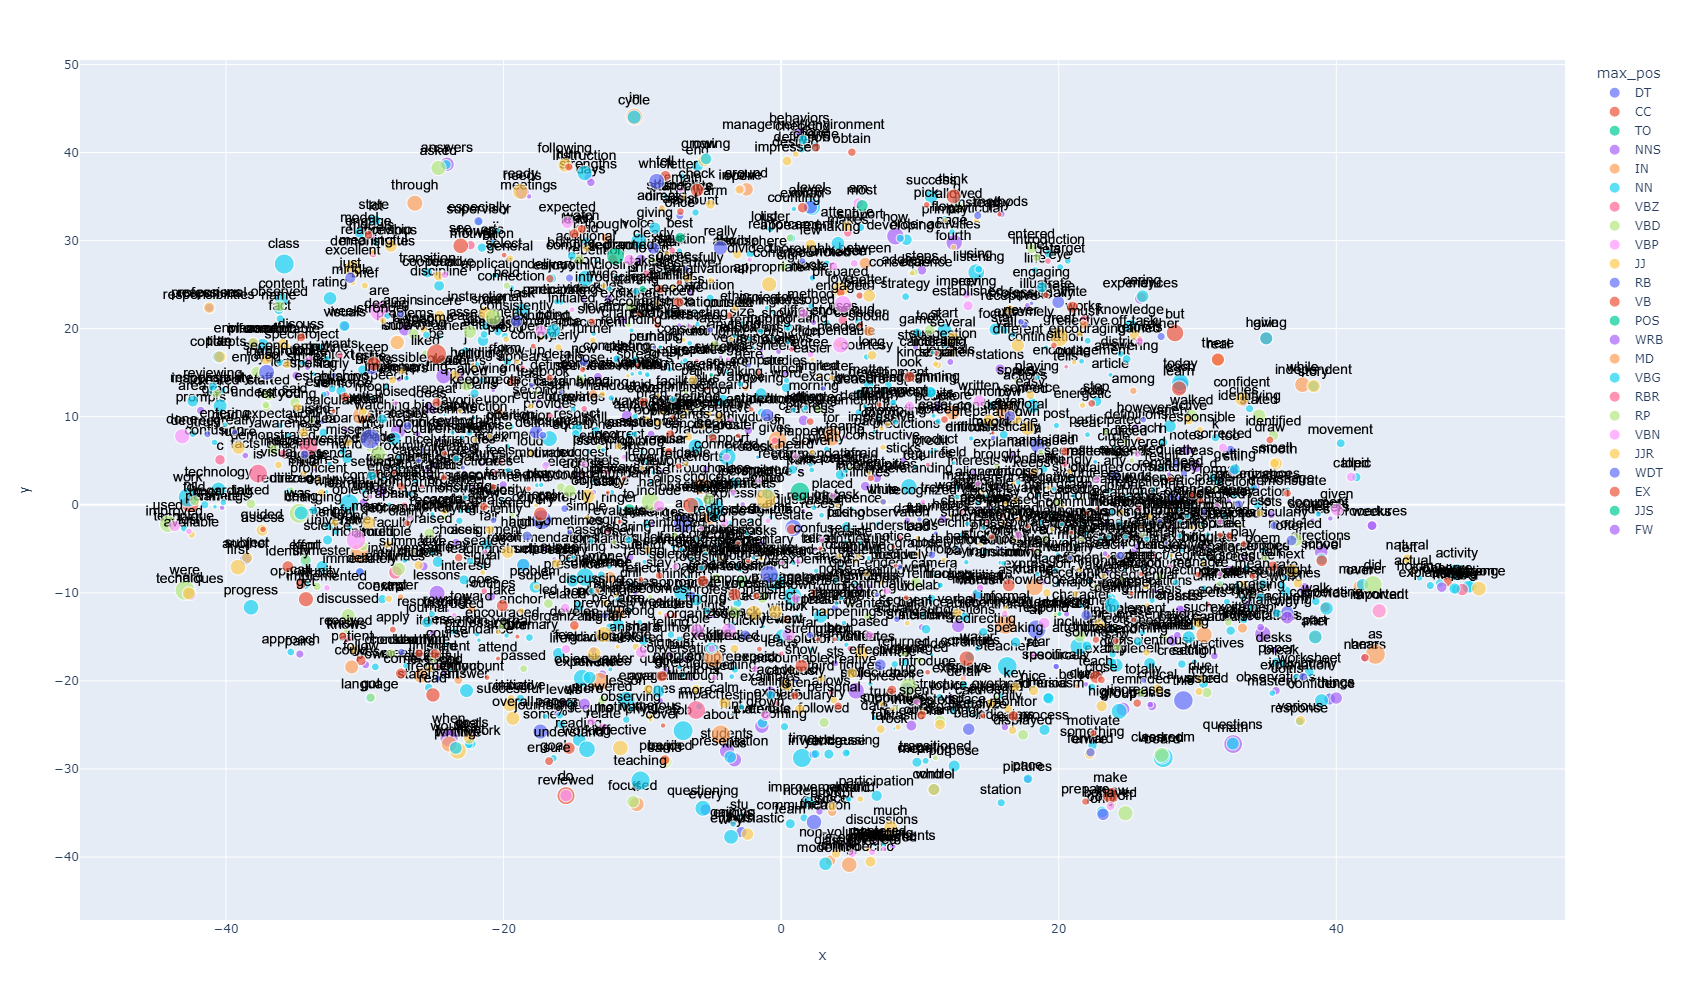

In [148]:
px.scatter(X.reset_index(), 'x', 'y', 
           text='term_str', 
           color='max_pos', 
           hover_name='term_str',          
           size='dfidf',
           height=1000).update_traces(
                mode='markers+text', 
                textfont=dict(color='black', size=14, family='Arial'),
                textposition='top center')

# Riffs

## Length of feedback historgram

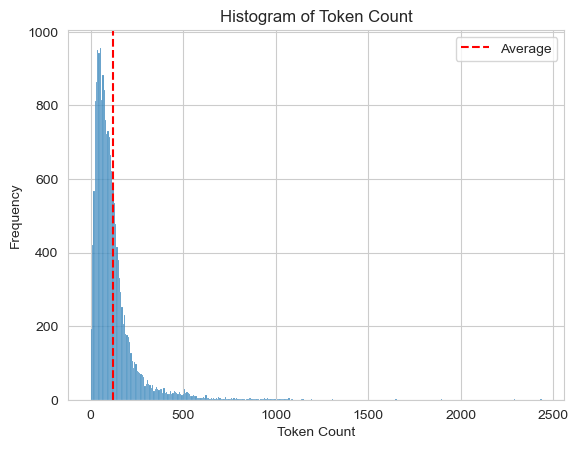

In [10]:
# Set the style of seaborn
sns.set_style("whitegrid")

# Create the histogram using seaborn
sns.histplot(data=LIB, x='token_count')

# Calculate the average of token_count
average_token_count = LIB['token_count'].mean()

# Add the average line
plt.axvline(x=average_token_count, color='r', linestyle='--', linewidth=1.5, label='Average')

# Set labels and title
plt.xlabel('Token Count')
plt.ylabel('Frequency')
plt.title('Histogram of Token Count')

# Add legend
plt.legend()

## Length of feedback by supervisor

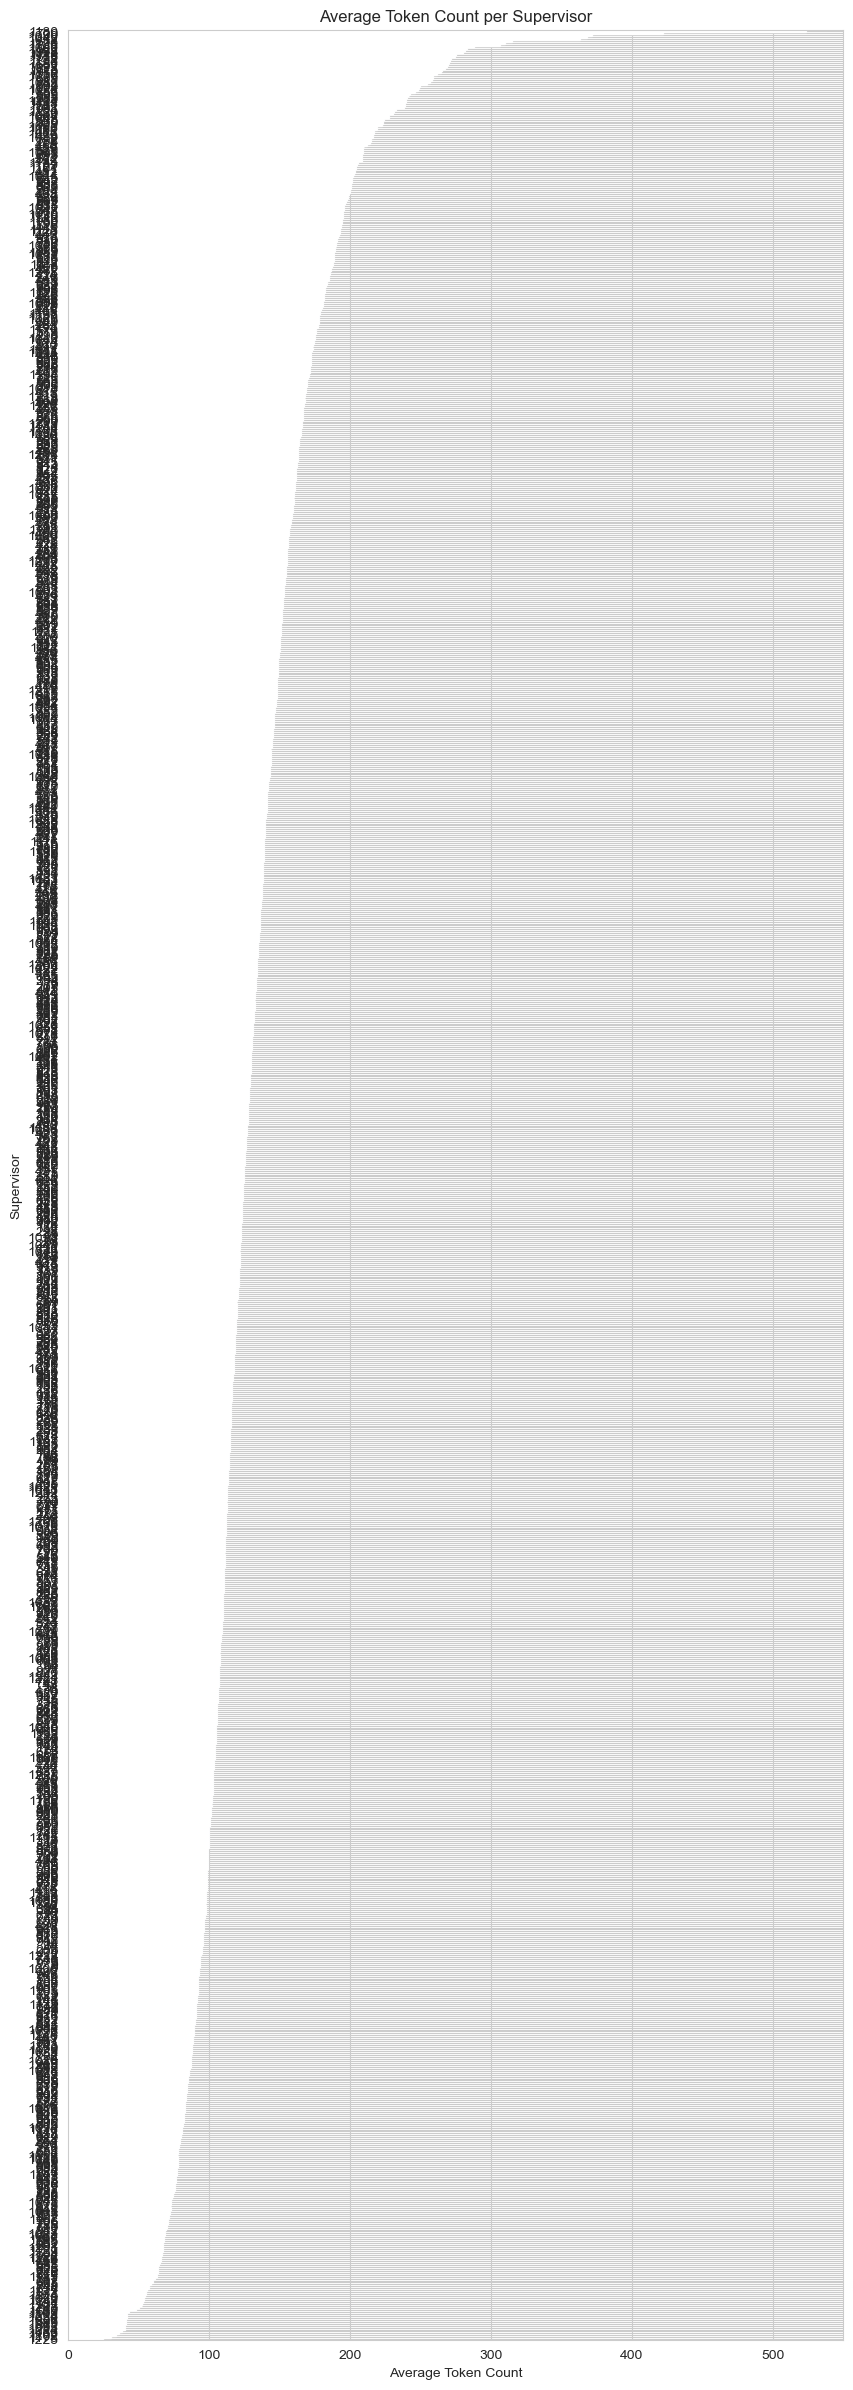

In [87]:
# Compute the average token_count grouped by supervisor
grouped_data = LIB.groupby('supervisor_id')['token_count'].mean().sort_values(ascending=True)

# Plotting
grouped_data.plot(kind='barh', figsize=(10, 30), color='skyblue')
plt.xlabel('Average Token Count')
plt.ylabel('Supervisor')
plt.title('Average Token Count per Supervisor')
plt.show()

## Relationship between feedback length and average score

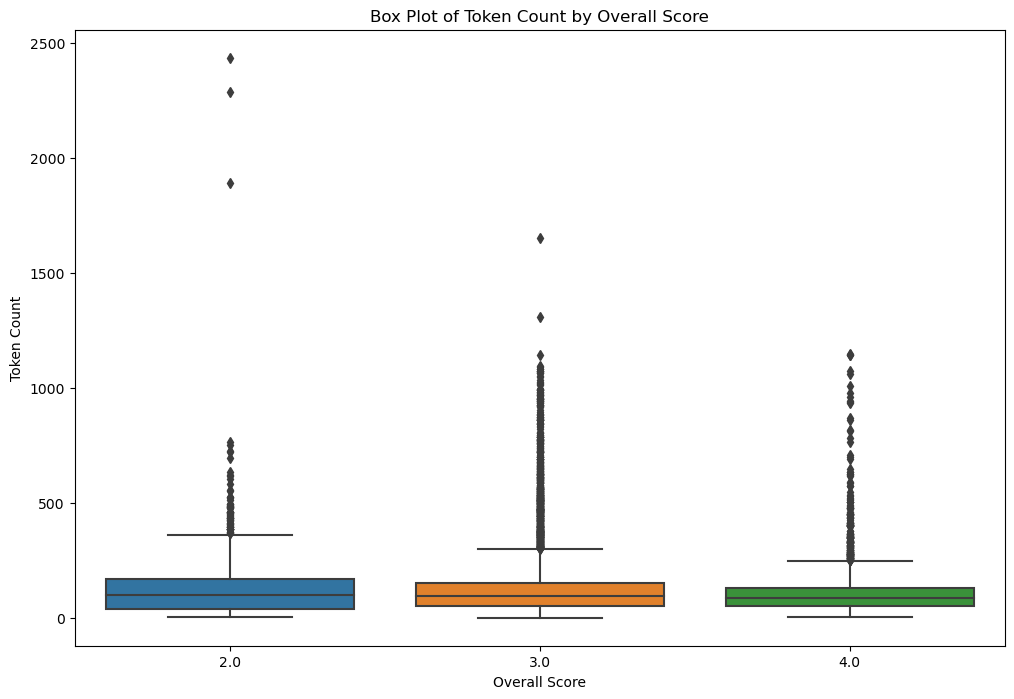

In [222]:
# Assuming 'LIB' DataFrame is already loaded and cleaned of NA's
# Check and clean NA's if not already done
LIB.dropna(subset=['token_count', 'avgscore'], inplace=True)

# Create a box plot
plt.figure(figsize=(12, 8))  # Set the figure size
sns.boxplot(x='avgscore', y='token_count', data=LIB)

plt.title('Box Plot of Token Count by Overall Score')
plt.xlabel('Overall Score')
plt.ylabel('Token Count')
plt.show()

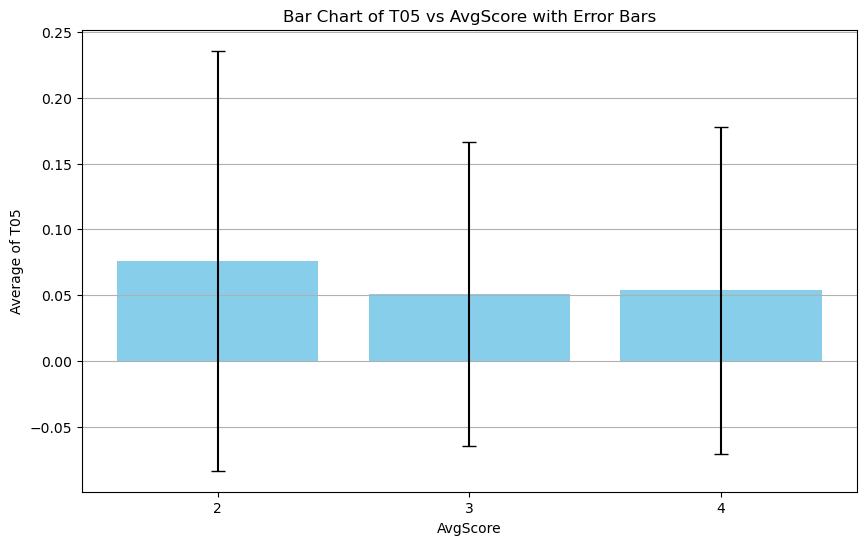

In [236]:
# Joining DataFrames on indices
joined_df = THETA.join(LIB, how='inner')

stats_df = joined_df.groupby('avgscore')['T05'].agg(['mean', 'std']).reset_index()

plt.figure(figsize=(10, 6))
plt.bar(stats_df['avgscore'], stats_df['mean'], yerr=stats_df['std'], capsize=5, color='skyblue')
plt.title('Bar Chart of T05 vs AvgScore with Error Bars')
plt.xlabel('AvgScore')
plt.ylabel('Average of T05')
plt.xticks(stats_df['avgscore'])  # Ensure all avgscores are shown as x-ticks
plt.grid(True, axis='y')  # Enable grid only horizontally
plt.show()